## Gender classification based on audio recordings

### 1 Web-Scrape . Batch download all compressed files containing the audio recordings

The dataset consisting on 62,440 audio samples compressed (tgz) in sets of 10 files was automatically downloaded from the url 
http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit

The Python package Beautiful Soup for parsing HTML and XML documents makes this task easy and straight forward.

Below there is a sample of the key lines of the code to extract the links to the compressed files and download them.                                
But the file **scrape.py** can be run to do the task. It will create a raw/ folder in the current directory and download all .tgz files into it

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import shutil
import os

URL = "http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/"

def download_file(from_url, local_path):
    r = requests.get(from_url, stream=True)
    with open(local_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

def batch_download(matches):
    for match in matches:
        file_url = os.path.join(URL, match['href'])
        file_local = os.path.join('raw', match['href'])
        download_file(file_url, file_local)

response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')
matches = soup.find_all('a', attrs={"href": re.compile("tgz")})

# Note: Don't run this here in the notebook. This is just for illustration purpose
#batch_download(matches) 

### 2 Unzip compressed audio files

Uncompress the tgz files using the Python library tarfile                                 
This, together with number 1 (the downloading part) only needs to be done once, at first. 
This is just illustrative.                                 
The file **unzipper.py** can be run to do this.                                

In [6]:
import os
import tarfile

raw_folder = './raw/'

#don't run this in the notebook

#for f in os.listdir(raw_folder):
#    if f.endswith('.tgz'):
#        tar = tarfile.open(os.path.join(raw_folder, f))
#        tar.extractall(raw_folder) #dont run in notebook
#        tar.close()


### 3 Feature extraction

Now comes the interesting part.
First the contents of every wave file is read, then the features are extracted and saved into a pandas dataframe.                                
In addition to the wave file, the README files are also parsed to extract metadata: gender, age range and pronunciation                                 

Notably, we will need **Scipy wavfile** to get the audio data, **Scipy stats** to extract the main features and **Numpy** and its fast fourier transform **fft** and **fftfreq** to extrapolate the wav data to frequencies 

Again the feature extraction (including the steps below here) can be run independently using **featureExtractor.py**

In [7]:
import pandas as pd
import re
import scipy.stats as stats
from scipy.io import wavfile
import numpy as np
import os

Define the path to the folder where all the uncompressed sample folders are

In [8]:
raw_folder = './raw/'

Get a list with the names of the uncompressed folders that contain the audio files

In [9]:
samples = [d for d in os.listdir(raw_folder) if os.path.isdir(os.path.join(raw_folder, d))]
n_samples = len(samples)

Create an empty pandas dataframe that will contain the features

In [10]:
columns=['nobs', 'mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr', 
 'user_name', 'sample_date', 'age_range', 'pronunciation', 'gender' ]

myData = pd.DataFrame(columns=columns)

Define some regular expressions to homogenize the different used formats

In [11]:
pattern_date = re.compile('[0-9]{8}')

female_pattern = re.compile('[Ff]emale')
male_pattern = re.compile('[Mm]ale')

american_pattern = re.compile('[Aa]merican')
british_pattern = re.compile('[Bb]ritish')
european_pattern = re.compile('[Ee]uropean')
indian_pattern = re.compile('[Ii]ndian')
australian_pattern = re.compile('[Aa]ustralian')

adult_pattern = re.compile('[Aa]dult')
youth_pattern = re.compile('[Yy]outh')
senior_pattern = re.compile('[Ss]enior')

#### Define some functions that we will use to extract the metadata and more importantly the features from the wav files

In [12]:
def get_metadata(readme_file):

    #define variables in case startswith does not work:
    gender, age_range, pronunciation = 'not specified', 'not specified', 'not specified' 
    for line in open(readme_file):
        if line.startswith("Gender:"): 
            gender = line.split(":")[1].strip()
        elif line.startswith("Age Range:"): 
            age_range = line.split(":")[1].strip()
        elif line.startswith("Pronunciation dialect:"): 
            pronunciation = line.split(":")[1].strip()
    return gender, age_range, pronunciation

In [13]:
def get_features(frequencies):

    print "\nExtracting features "
    nobs, minmax, mean, variance, skew, kurtosis = stats.describe(frequencies)
    median    = np.median(frequencies)
    mode      = stats.mode(frequencies).mode[0]
    std       = np.std(frequencies)
    low,peak  = minmax
    q75,q25   = np.percentile(frequencies, [75 ,25])
    iqr       = q75 - q25
    return nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr

In [14]:
def get_date(sample_name):

    try:
        date = pattern_date.search(sample_name).group()
    except AttributeError:
        date = '20000000'
    return date

In [15]:
def get_user_name(sample_name):

    return re.compile("[-_]").split(sample_name)[0]

In [16]:
def homogenize_format(gender, age_range, pronunciation):

    #Homogenize gender format
    if female_pattern.search(gender): gender = 'Female' 
    elif male_pattern.search(gender): gender = 'Male'
    else: gender = 'not_specified'

    #Homogenize pronunciation format to 5/6 categories
    if british_pattern.search(pronunciation)     : pronunciation = 'British' 
    elif american_pattern.search(pronunciation)  : pronunciation = 'American'
    elif european_pattern.search(pronunciation)  : pronunciation = 'European'
    elif indian_pattern.search(pronunciation)    : pronunciation = 'Indian'
    elif australian_pattern.search(pronunciation): pronunciation = 'Australian'
    else: pronunciation = 'Other'

    #Homogenize age range format
    if adult_pattern.search(age_range)   : age_range = 'Adult' 
    elif youth_pattern.search(age_range) : age_range = 'Youth'
    elif senior_pattern.search(age_range): age_range = 'Senior'
    else: age_range = 'Unknown'

    return gender, age_range, pronunciation

In [17]:
def get_frequencies(sample_wav_folder):
    '''
    extract list of dominant frequencies in sliding windows of duration defined by 'step' for each of the 10 wav files and return an array
    frequencies_lol: list of lists
    every item in this list will contain 10 lists corresponding to each of the 10 wav files in every sample
    and the lists within the list will contain a range of *filtered* frequencies corresponding to sliding windows within each wav file
    '''
    frequencies_lol = [] 
    for wav_file in os.listdir(sample_wav_folder):
        rate, data = wavfile.read(os.path.join(sample_wav_folder, wav_file))

        #get dominating frequencies in sliding windows of 500ms
        step = rate/2 #8000 sampling points every 0.5 sec (500ms)
        window_frequencies = []
        for i in range(0,len(data),step):
            ft = np.fft.fft(data[i:i+step])
            freqs = np.fft.fftfreq(len(ft))
            imax = np.argmax(np.abs(ft))
            freq = freqs[imax]
            freq_in_hz = abs(freq *rate)
            window_frequencies.append(freq_in_hz)
            filtered_frequencies = [f for f in window_frequencies if 10<f<300 and not 46<f<66] 
            # I see noise at 50Hz and 60Hz. See plots below
            frequencies_lol.append(filtered_frequencies)

    frequencies = [item for sublist in frequencies_lol for item in sublist]

    return frequencies

#### And now iterate over the samples (folders) and look into the wav folder within them to read the wav files

In [ ]:
for i in range(n_samples):
        
    #get the path to the wav files (.raw/wav) and to the README file (.raw/etc/README)
    sample = sorted(samples)[i]
    sample_folder = os.path.join(raw_folder, sample)
    sample_wav_folder = os.path.join(sample_folder, 'wav')
    readme_file = os.path.join(sample_folder, 'etc', 'README')

    #get the information from the readme file: gender, age_range, pronunciation
    date = get_date(sample)
    user_name = get_user_name(sample)
     if os.path.isfile(readme_file):
            gender, age_range, pronunciation = get_metadata(readme_file)
    gender, age_range, pronunciation = homogenize_format(gender, age_range, pronunciation)
        
    #Read and extract the information from the wav files:        
    if os.path.isdir(sample_wav_folder): #some of the samples don't contain a wav folder (Ex: 'LunaTick-20080329-vf1')
        frequencies = get_frequencies(sample_wav_folder)
        if len(frequencies) > 10: 
            #for some of the files (ex: Aaron-20130527-giy) 
            #I only recover frequencies of 0.0 (even if I don't split in chunks) which is not integrated into my lol and frequencies is empty
            nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequencies)
            sample_dict = {'nobs':nobs, 'mean':mean, 'skew':skew, 'kurtosis':kurtosis,
                           'median':median, 'mode':mode, 'std':std, 'low': low,
                           'peak':peak, 'q25':q25, 'q75':q75, 'iqr':iqr, 
                           'user_name':user_name, 'sample_date':date, 
                           'age_range':age_range, 'pronunciation':pronunciation,
                           'gender':gender}
            print "\nappending %s sample %s : %s"%(gender, sample, sample_dict)

            #Save to my pandas dataframe
            myData.loc[i] = pd.Series(sample_dict)
        
    #and store it to a file
    myData.to_csv('myData_filtered.csv')


### 4 Plot individual wav files 

The code for this plots is also in **sample_plots.py**

In [18]:
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})

In [19]:
wav_file = '/home/vitalv/voice-gender-classifier/raw/chris-20090325-esw/wav/a0060.wav'#Noise at 50Hz #check plot_frequency
#wav_file = '/home/vitalv/voice-gender-classifier/raw/anonymous-20100621-cdr/wav/a0166.wav'
rate, data = wavfile.read(wav_file)

#### Amplitude vs Time

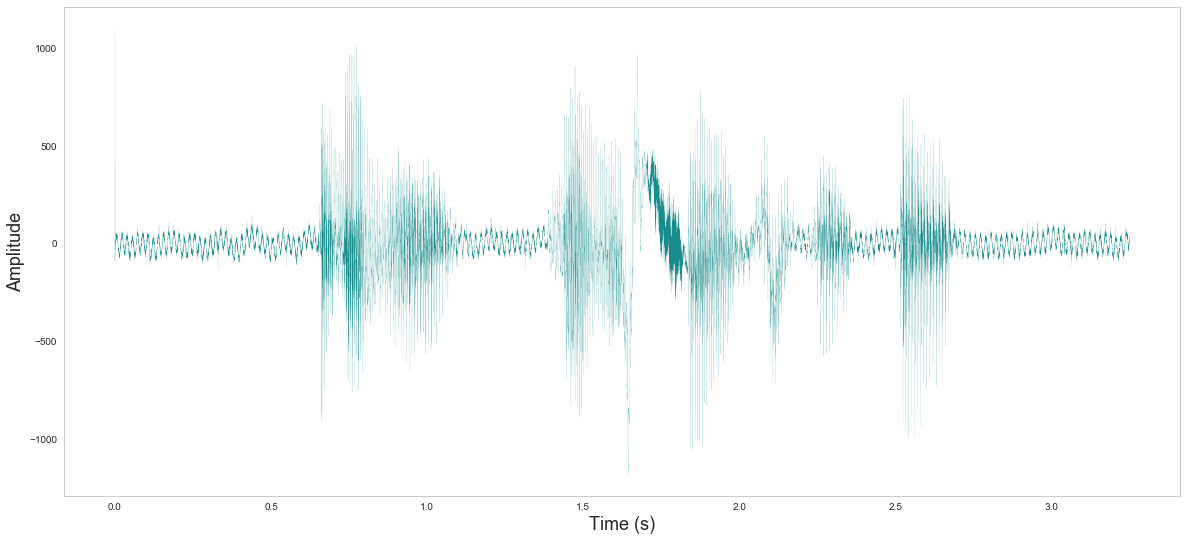

In [20]:
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.figure(1, figsize=(20,9))
plt.subplot(111)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.show()


#### Frequency

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


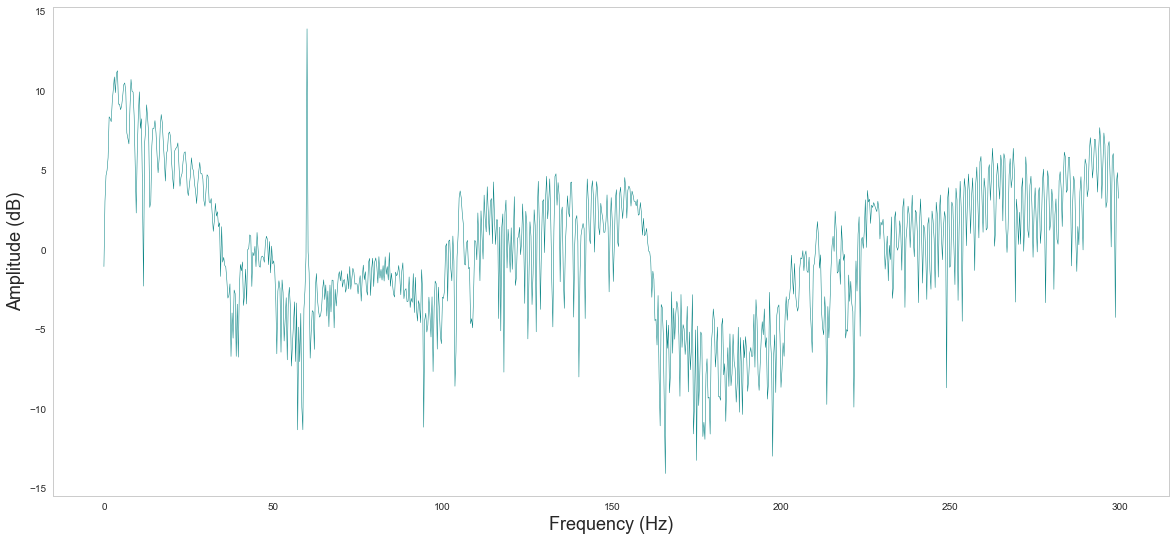

In [21]:
fourier = np.fft.fft(data)

n = len(data)
fourier = fourier[0:(n/2)]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.figure(1,figsize=(20,9))
plt.plot(x, y, color='teal', linewidth=0.5)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude (dB)', fontsize=18)
plt.show()

Note the spike at 52 Hz. Present in many samples. Most likely noise

#### And Heatmap

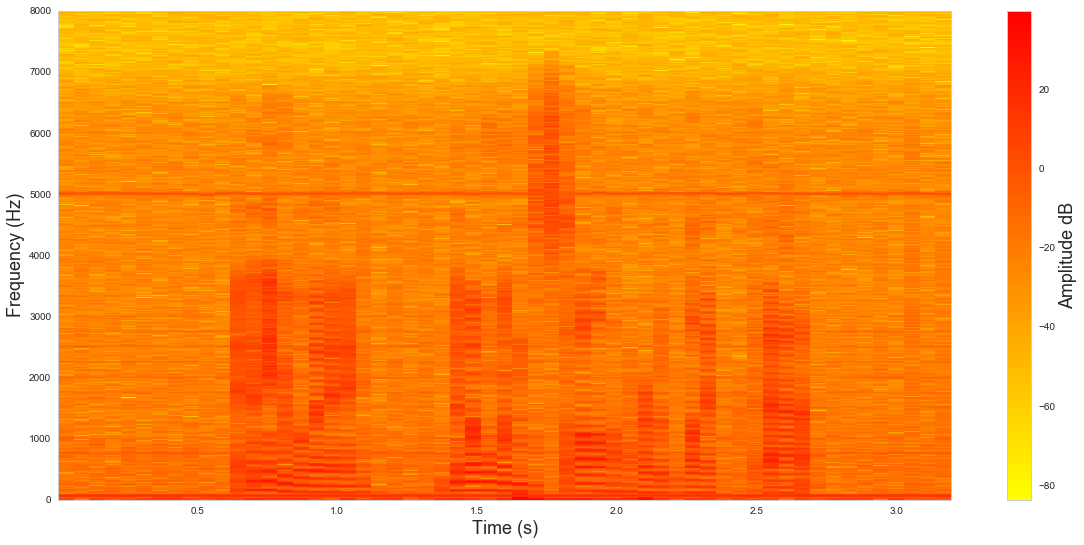

In [22]:
# See http://myinspirationinformation.com/uncategorized/audio-signals-in-python/

plt.figure(1,figsize=(20,9))
plt.subplot(111)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Frequency (Hz)', fontsize=18)
cbar.set_label('Amplitude dB', fontsize=18)
plt.show()

### 5 Classification models

Bunch of sklearn imports. Rest of modules have already been imported

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 
sb.set(font_scale = 2)
sb.set_style("whitegrid", {'axes.grid' : False})

Read dataframe that I saved in step 3 (feature extraction)

In [24]:
mydata = pd.read_csv('myData_filtered.csv')

#### Basic barplots on number of male/female; pronunciation types; age_ranges

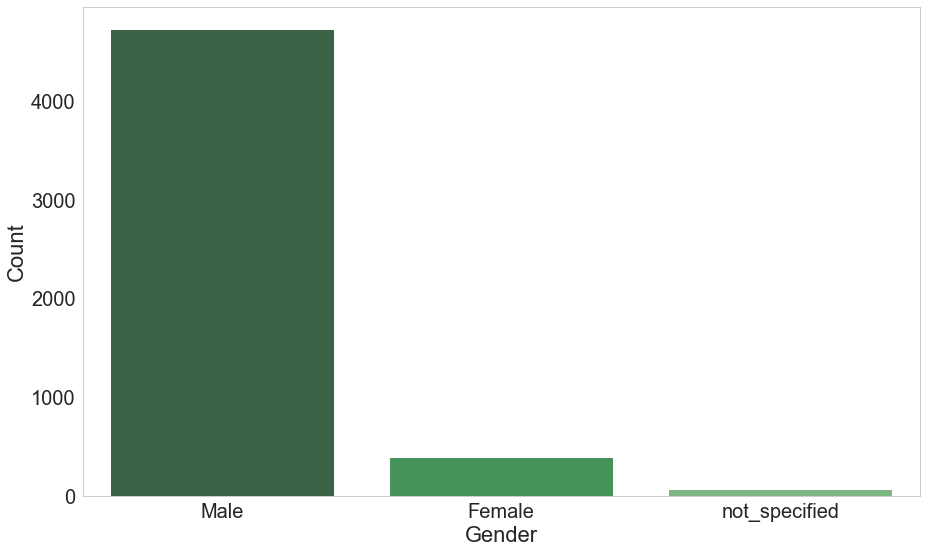

In [25]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='gender', data=mydata, palette='Greens_d')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

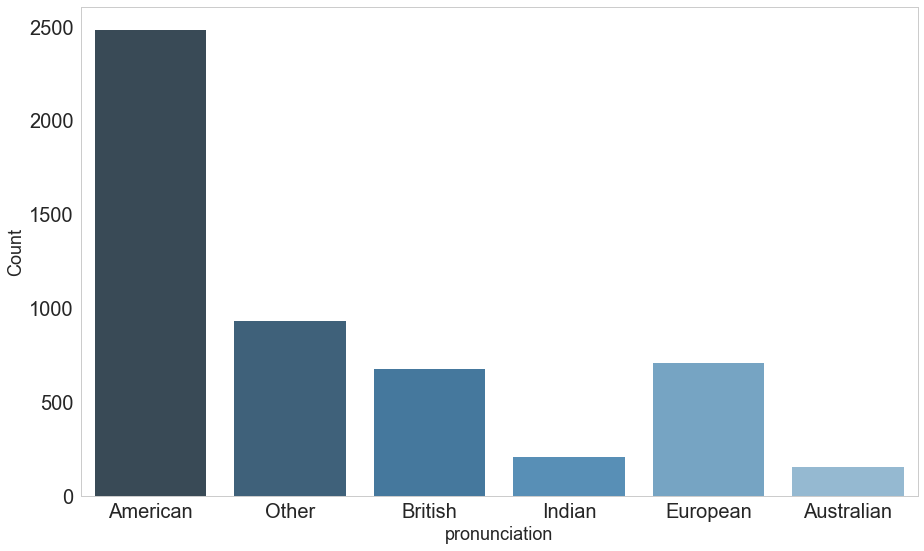

In [26]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='pronunciation', data=mydata, palette='Blues_d')
plt.xlabel('pronunciation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

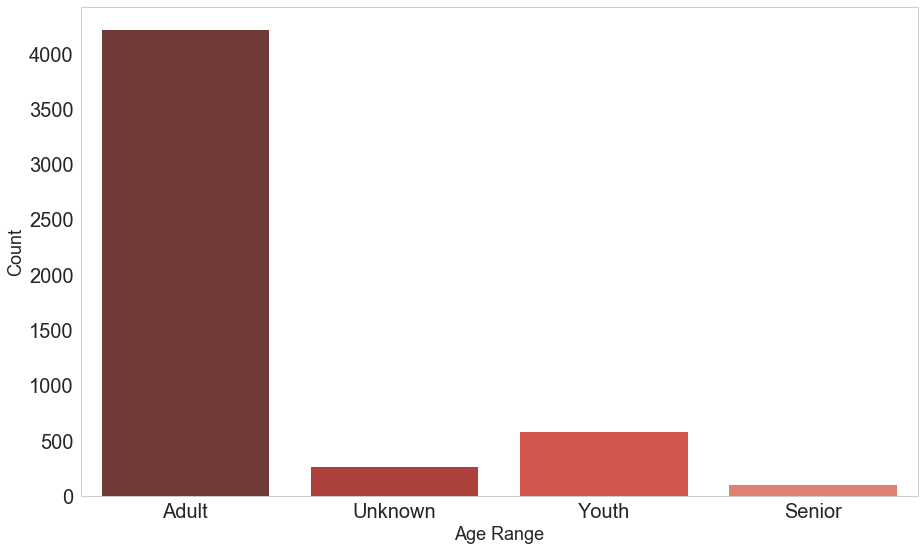

In [27]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='age_range', data=mydata, palette='Reds_d')
plt.xlabel('Age Range', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

### Features Distribution on the split (male/female) dataset

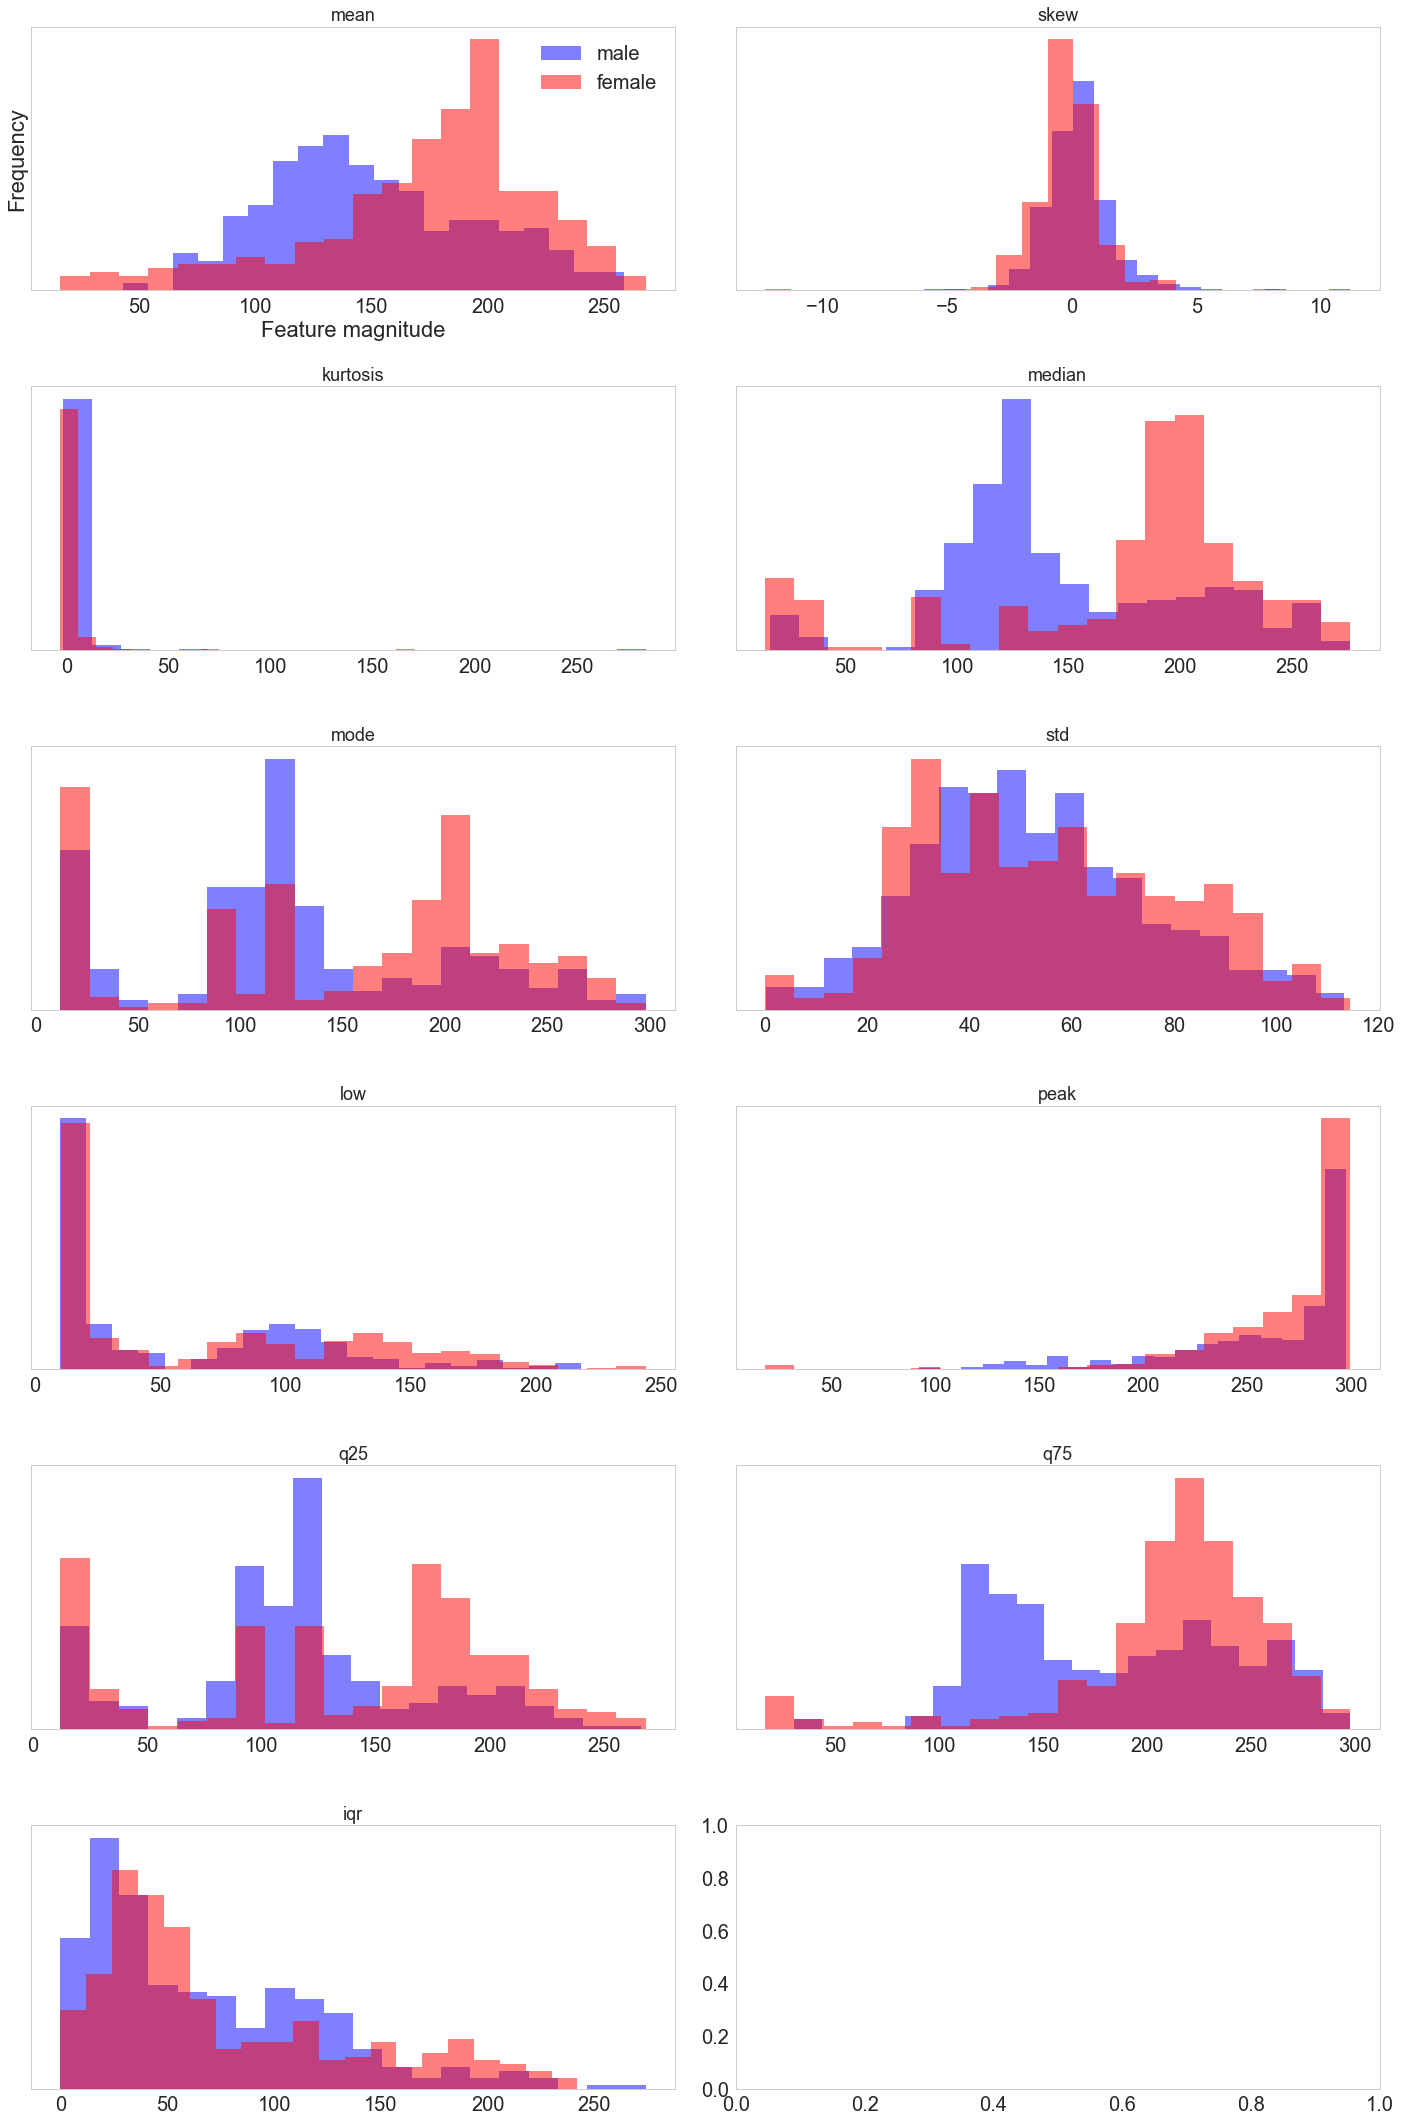

In [28]:
import warnings; warnings.simplefilter('ignore')

female = mydata.loc[mydata.gender=='Female']
male = mydata.loc[mydata.gender=='Male']
#take a sample of the male population of equal size of the female (otherwise the frequencies will be much lower for female)
male_ = male.sample(len(female))

features = ['mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr']

#Plot the histograms
fig, axes = plt.subplots(6, 2, figsize=(20,30))

ax = axes.flatten() #ravel()

for i in range(len(features)):
    ax[i].hist(male_.ix[:,features[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(female.ix[:, features[i]], bins=20, color='red', alpha=.5)
    ax[i].set_title(features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["male", "female"], loc="best")
fig.tight_layout()

plt.show()


### Modeling using different ML algorithms from sklearn

In [29]:
#Prepare data for modeling
mydata = mydata[mydata.gender != 'not_specified']
mydata.loc[:,'gender'][mydata['gender']=="Male"] = 0
mydata.loc[:,'gender'][mydata['gender']=="Female"] = 1


mydata_train, mydata_test = train_test_split(mydata, random_state=0, test_size=.2)
scaler = StandardScaler()
scaler.fit(mydata_train.ix[:,features])
X_train = scaler.transform(mydata_train.ix[:,features])
X_test = scaler.transform(mydata_test.ix[:,features])
y_train = list(mydata_train['gender'].values)
y_test = list(mydata_test['gender'].values)

#Train decision tree model
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print("\nDecision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

#Train random forest model
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("\nRandom Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

#Train gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
print("\nGradient Boosting")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

#Train support vector machine model
svm = SVC().fit(X_train, y_train)
print("\nSupport Vector Machine")
print("Accuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svm.score(X_test, y_test)))

#Train neural network model
mlp = MLPClassifier(random_state=0).fit(X_train, y_train)
print("\nMultilayer Perceptron")
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))


Decision Tree
Accuracy on training set: 1.000
Accuracy on test set: 0.886

Random Forests
Accuracy on training set: 0.989
Accuracy on test set: 0.920

Gradient Boosting
Accuracy on training set: 0.951
Accuracy on test set: 0.924

Support Vector Machine
Accuracy on training set: 0.929
Accuracy on test set: 0.914

Multilayer Perceptron
Accuracy on training set: 0.934
Accuracy on test set: 0.915


In [30]:
def plot_feature_importances_mydata(model, c):
    n_features = X_train.shape[1]
    plt.figure(1,figsize=(13,9))
    plt.barh(range(n_features), model.feature_importances_, align='center', color=c)
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Variable importance")
    plt.ylabel("Independent Variable")
    plt.title(model.__class__.__name__)
    plt.show()

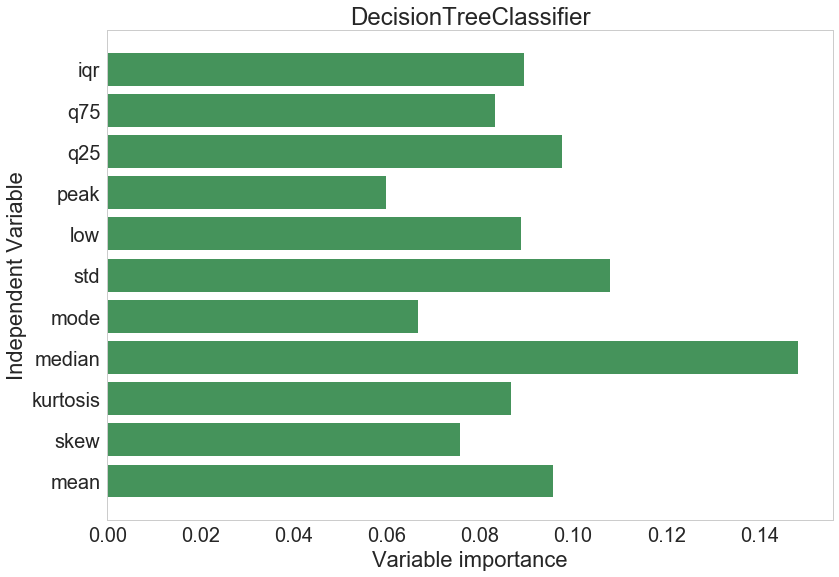

In [31]:
plot_feature_importances_mydata(tree,  '#45935B')

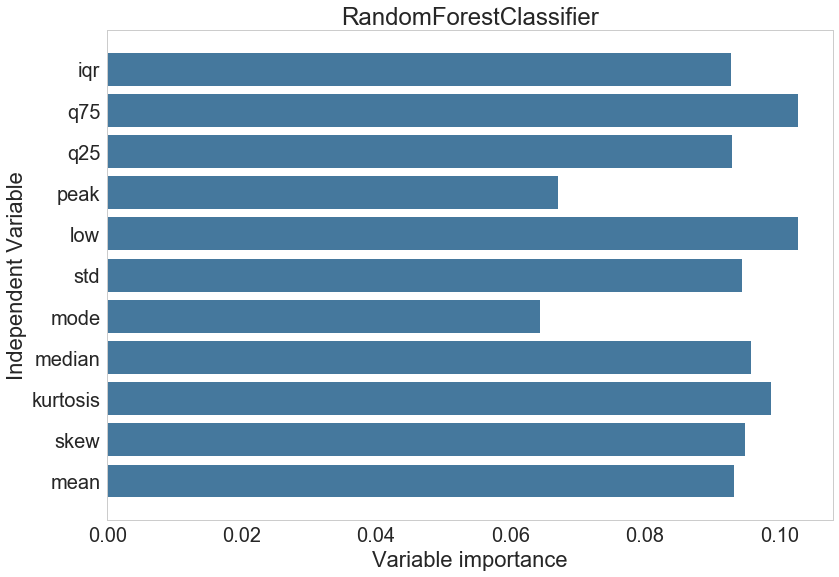

In [32]:
plot_feature_importances_mydata(forest, '#45789D')

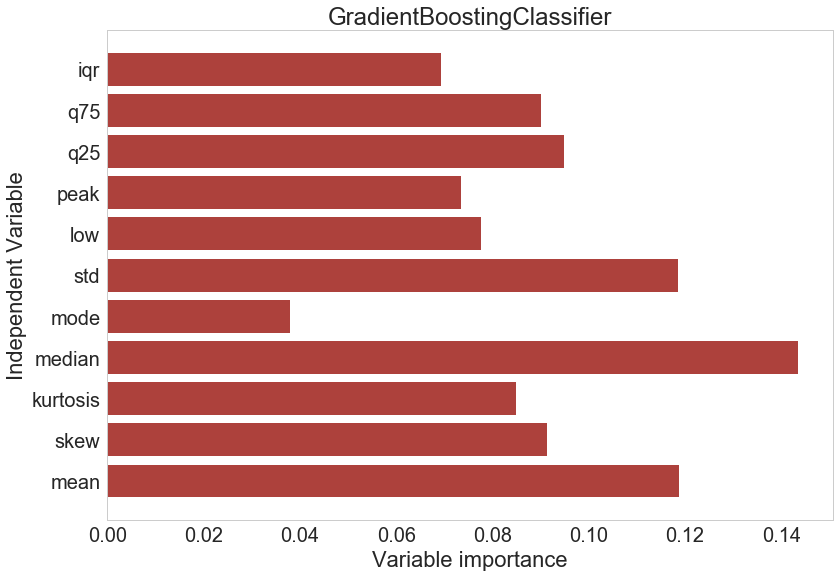

In [33]:
plot_feature_importances_mydata(gbrt, '#AD413C')

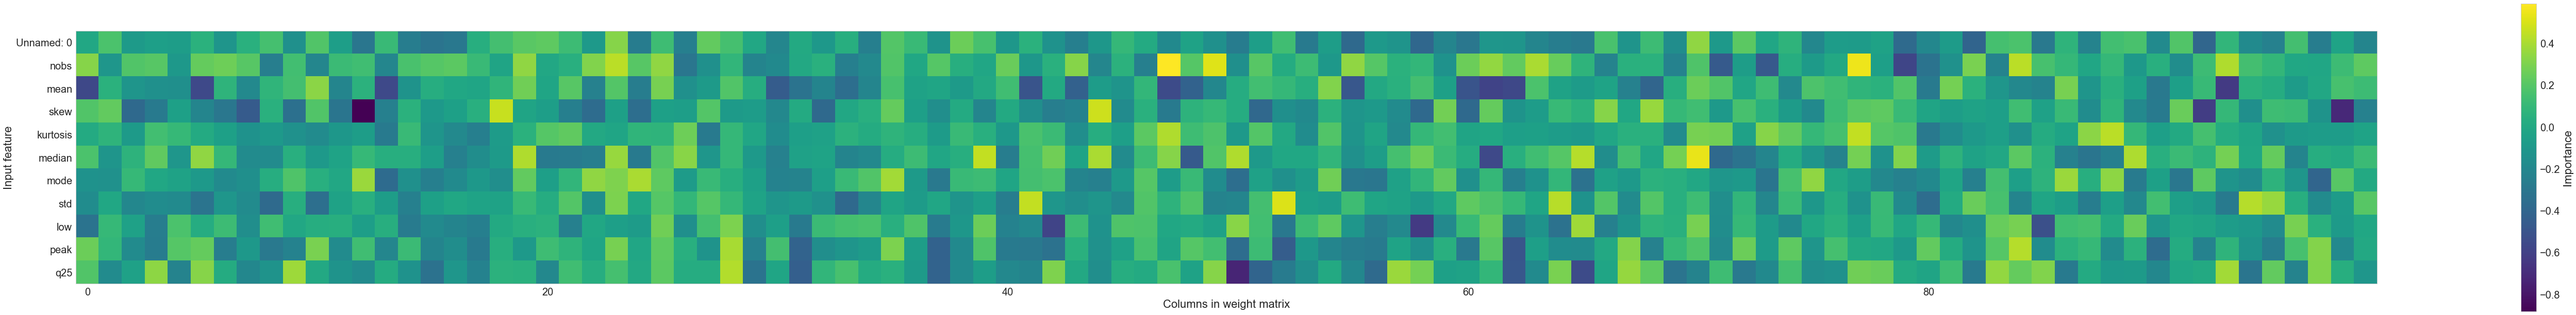

In [34]:
#Plot the heatmap on first layer weights for neural network
plt.figure(figsize=(100, len(features)))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(features)), list(mydata))
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar().set_label('Importance')

plt.show()